In [171]:
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'figure.figsize': (15,8)})

In [172]:
class CallType(object):
    def __init__(self, name, eps, M):
        self.name = name
        self.eps = eps
        self.M = M
        self.L = 2
        self.X0 = 100
        self.K = 100
        self.T = 1
        
class Params():
    def __init__(self):
        self.r = 0.05
        self.sig = 0.2

# class Option(object):
#     def __init__(self, name, eps, M):
#         self.name = name
#         self.eps = eps
#         self.M = M
#         self.L = 2
#         self.X0 = 100
#         self.K = 100
#         self.T = 1
#         self.r = 0.05
#         self.sig = 0.2
    
#     def calc_option2(self,Nl,l,Npl=10**4):
#         num_rem=Nl #Initialise remaining samples for while loop
#         suml=np.zeros(7)    
#         Nsteps=self.M**l #Number of fine steps
#         dt=self.T/Nsteps
#         sqrt_dt=np.sqrt(dt)

#         while (num_rem>0): #<---Parallelise this while loop
#             N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
#             num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 

#             #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
#             Xf=self.X0*np.ones(N_loop)
#             Xc=self.X0*np.ones(N_loop)
#             if self.name=="Lookback":
#                 Mf=self.X0*np.ones(N_loop)
#                 Mc=self.X0*np.ones(N_loop)
#             if self.name=="Asian":
#                 Af=0.5*dt*Xf
#                 Ac=0.5*self.M*dt*Xc
#             dWc=np.zeros(N_loop)

#             for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
#                 dWf=np.random.randn(N_loop)*sqrt_dt
#                 dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
#                 Xf+=self.r*Xf*dt + self.sig*Xf*dWf
#                 if self.name=="Lookback":
#                     Mf=np.minimum(Xf,Mf)
#                 if self.name=="Asian":
#                     Af+=Xf*dt

#                 if j%self.M==0: #if j is integer multiple of M...
#                     Xc+=self.r*Xc*self.M*dt + self.sig*Xc*dWc #...Develop coarse path
#                     if self.name=="Lookback":
#                         Mc=np.minimum(Xc,Mc)
#                     if self.name=="Asian":
#                         Ac+=Xc*self.M*dt
#                     dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

#             #Calculate payoffs etc.
#             if self.name=="European":
#                 Pf=np.maximum(0,Xf-self.K)
#             elif self.name=="Lookback":
#                 beta = 0.5826  #special factor for offset correction
#                 Pf = Xf - Mf*(1-beta*self.sig*sqrt_dt)
#             elif self.name=="Digital":
#                 Pf=self.K*(Xf>self.K).astype(np.int_)
#             elif self.name=="Asian":
#                 Af-=0.5*Xf*dt
#                 Ac-=0.5*Xc*self.M*dt
#                 Pf=np.maximum(0,Af-self.K)

#             Pf=np.exp(-self.r*self.T)*Pf #Payoff at fine level
#             sumPf=np.sum(Pf)
#             sumPf2=np.sum(Pf**2)
#             if l==0:
#                 suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
#             else:
#                 if self.name=="European":
#                     Pc=np.maximum(0,Xc-self.K)
#                 elif self.name=="Lookback":
#                     Pc = Xc - Mc*(1-beta*self.sig*np.sqrt(self.M*dt)) 
#                 elif self.name=="Digital":
#                     Pc=self.K*(Xc>self.K).astype(np.int_)
#                 elif self.name=="Asian":
#                     Pc=np.maximum(0,Ac-self.K)

#                 Pc=np.exp(-self.r*self.T)*Pc #Payoff at coarse level
#                 dP_l=Pf-Pc #Payoff difference
#                 sumPc=np.sum(Pc)
#                 sumPc2=np.sum(Pc**2)
#                 fg=np.sum(Pc*Pf)
#                 suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])

#         return suml

        

In [173]:
# option = Option('European',0.005,2)
# option.calc_option2(2,3)

In [174]:
def calc_option(calltype,Nl,l,Npl=10**4):
    params = Params()
    r = params.r
    sig = params.sig
    calltype_name = calltype.name
    M = calltype.M
    X0 = calltype.X0
    K = calltype.K
    T = calltype.T
    
    num_rem=Nl #Initialise remaining samples for while loop
    suml=np.zeros(7)    
    Nsteps=M**l #Number of fine steps
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
      
    while (num_rem>0): #<---Parallelise this while loop
        N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
        num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 
        
        #Initialise fine, coarse asset prices; coarse Brownian increment (BI)
        Xf=X0*np.ones(N_loop)
        Xc=X0*np.ones(N_loop)
        if calltype_name=="Lookback":
            Mf=X0*np.ones(N_loop)
            Mc=X0*np.ones(N_loop)
        if calltype_name=="Asian":
            Af=0.5*dt*Xf
            Ac=0.5*M*dt*Xc
        dWc=np.zeros(N_loop)
            
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*sqrt_dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            Xf+=r*Xf*dt + sig*Xf*dWf
            if calltype_name=="Lookback":
                Mf=np.minimum(Xf,Mf)
            if calltype_name=="Asian":
                Af+=Xf*dt
            
            if j%M==0: #if j is integer multiple of M...
                Xc+=r*Xc*M*dt + sig*Xc*dWc #...Develop coarse path
                if calltype_name=="Lookback":
                    Mc=np.minimum(Xc,Mc)
                if calltype_name=="Asian":
                    Ac+=Xc*M*dt
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0

        #Calculate payoffs etc.
        if calltype_name=="European":
            Pf=np.maximum(0,Xf-K)
        elif calltype_name=="Lookback":
            beta = 0.5826  #special factor for offset correction
            Pf = Xf - Mf*(1-beta*sig*sqrt_dt)
        elif calltype_name=="Digital":
            Pf=K*(Xf>K).astype(np.int_)
        elif calltype_name=="Asian":
            Af-=0.5*Xf*dt
            Ac-=0.5*Xc*M*dt
            Pf=np.maximum(0,Af-K)
        
        Pf=np.exp(-r*T)*Pf #Payoff at fine level
        sumPf=np.sum(Pf)
        sumPf2=np.sum(Pf**2)
        if l==0:
            suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
        else:
            if calltype_name=="European":
                Pc=np.maximum(0,Xc-K)
            elif calltype_name=="Lookback":
                Pc = Xc - Mc*(1-beta*sig*np.sqrt(M*dt)) 
            elif calltype_name=="Digital":
                Pc=K*(Xc>K).astype(np.int_)
            elif calltype_name=="Asian":
                Pc=np.maximum(0,Ac-K)
                
            Pc=np.exp(-r*T)*Pc #Payoff at coarse level
            dP_l=Pf-Pc #Payoff difference
            sumPc=np.sum(Pc)
            sumPc2=np.sum(Pc**2)
            fg=np.sum(Pc*Pf)
            suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
            
    return suml

In [175]:
def N_opt(V,eps,L,M):
    '''
    This shouldn't change depending on alpha, but will change according to gamma.
    Beta is implicitly included in V, since Vl <= hl**beta.
    '''
    sqrt_h=np.sqrt(M**(np.arange(0,L+1)))
    sqrt_V=np.sqrt(V)
    return np.ceil((2/eps**2)*np.sum(sqrt_V*sqrt_h)*sqrt_V/sqrt_h)

In [176]:
def mlmc(payoff,calltype,N0=10**3,**kwargs):
    '''
    Runs MLMC method for given mlmc_fn (e.g. mlmc_gbm) which returns an array of sums at each level: 
    suml=[d_Pl,d_Pl**2,Pl,Pl**2].
    __Inputs__
    mlmc_fn = function to call at a given level
    eps = desired accuracy
    N0 = default number of samples to use when initialising new level
    M=coarseness factor
    
    __Outputs__
    sums = array of sums of payoff differences between coarse and fine paths at each level and
           sum of payoffs at fine level, each column is a level
    N = final number of samples at each level
    '''
    eps = calltype.eps
    M = calltype.M
    L = calltype.L

    V=np.zeros(L+1) #Initialise variance vector of each levels' variance
    N=N0*np.ones(L+1) #Initialise num. samples vector of each levels' num. samples
    dN=N0*np.ones(L+1) #Initialise additional samples for this iteration vector for each level
    sums=np.zeros((7,L+1)) #Initialise sums array, each column is a level

    while (np.sum(dN)>0): #Loop until no additional samples asked for
        for l in range(L+1): 
            num=dN[l]
            if num>0: #If asked for additional samples...
                sums[:,l]+=payoff(calltype,int(num),l,**kwargs) #Call function which gives sums

        
        N+=dN #Increment samples taken counter for each level        
        V=np.maximum((sums[1,:]/N)-(sums[0,:]/N)**2,0) #Calculate variance based on updated samples
        Nl_new=N_opt(V,eps,L,M) #Estimate optimal number of samples at each level
        dN=np.maximum(0,Nl_new-N) #Number of additional samples
        if sum(dN > 0.01*N) == 0:
            if abs(sums[0,-1])/N[-1]>(M-1)*eps*np.sqrt(0.5):
                L+=1
                #Add extra entries for the new level and estimate sums with N0 samples 
                V=np.concatenate((V,np.zeros(1)), axis=0)
                N=np.concatenate((N,N0*np.ones(1)),axis=0)
                dN=np.concatenate((dN,N0*np.ones(1)),axis=0)
                sums=np.concatenate((sums,np.zeros((7,1))),axis=1)
                sums[:,L]+=payoff(calltype,N0,L,**kwargs)
    
    return sums,N

/Users/neju/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


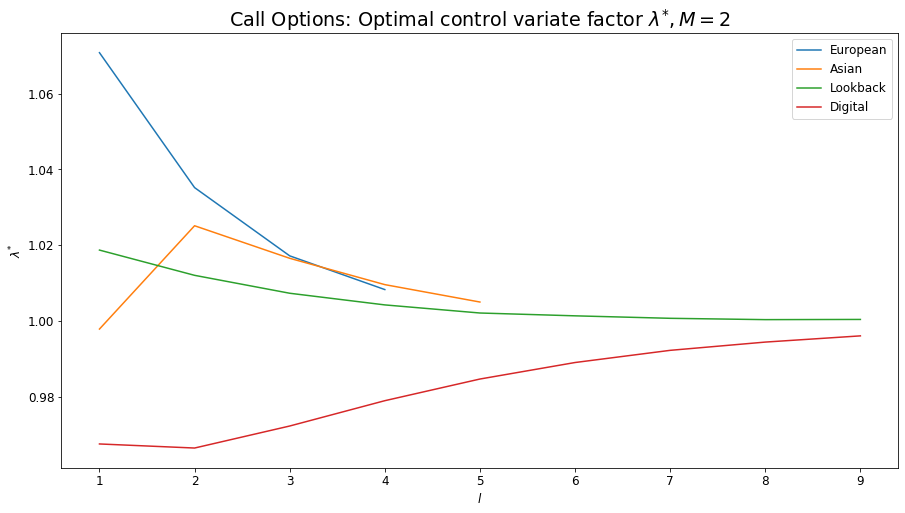

In [177]:
call_types = [CallType("European",0.01,2), CallType("Asian",0.01,2), CallType("Lookback",0.01,2), CallType("Digital",0.01,2)]

for call_type in call_types:
    sums, N = mlmc(calc_option, call_type)
    Vg = sums[5,:]/N-(sums[4,:]/N)**2
    lam = ((sums[6,:]/N)-(sums[2,:]/N)*(sums[4,:]/N))/Vg
    plt.plot(range(len(N)),lam,label=call_type.name)

plt.xlabel('$l$')
plt.ylabel('$\lambda^{*}$')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Call Options: Optimal control variate factor $\lambda^{*}, M=2$');
plt.savefig('lambdaCallOptions')
plt.legend()
plt.show()

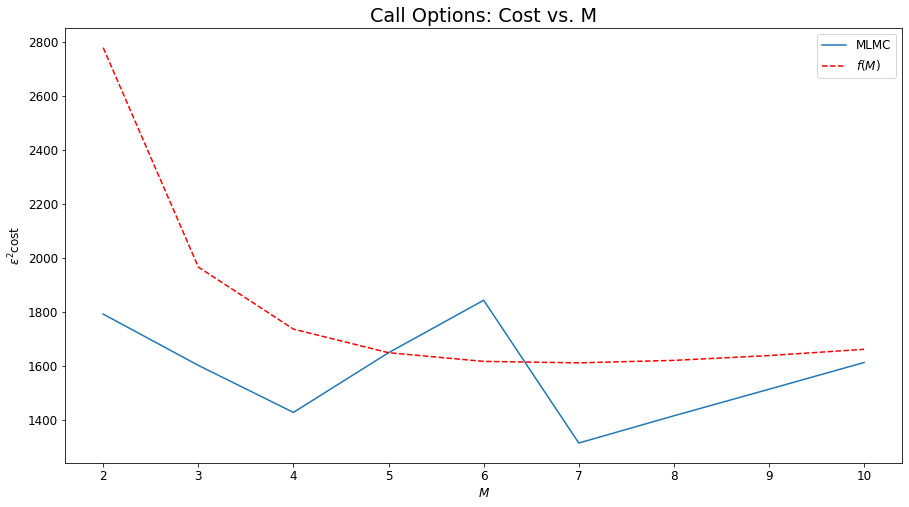

In [178]:
M=np.arange(2,11,1)
cost_mlmc=[]
cost_mc=[]

for m in M:
    calltype = CallType('European',0.005,m)
    sums,N=mlmc(calc_option,calltype)
    L=len(N)-1
    means_p=sums[2,:]/N
    V_p=(sums[3,:]/N)-means_p**2
    cost_mlmc+=[(N[0]+(1+1/m)*np.sum(N[1:]*(m**np.arange(1,L+1))))*calltype.eps**2]
    cost_mc+=[2*sum(V_p*m**np.arange(L+1))]
    
sc=cost_mlmc[3]/((M[3]-1/M[3])/(np.log(M[3]))**2)

plt.plot(M,cost_mlmc,label='MLMC')
plt.plot(M,sc*(M-1/M)/(np.log(M))**2,'r--',label='$f(M)$')
plt.xlabel('$M$');
plt.ylabel('$\epsilon^{2}$cost')
plt.title('Call Options: Cost vs. M');
plt.savefig('Comparison_Cost_fofM')
plt.legend()
plt.show()